https://docs.ray.io/en/latest/workflows/index.html

In [1]:
import time
import ray
from ray import workflow

In [2]:
# needs fix for pvc
ray.init(storage="/ray-on-the-edge-demo/workflows/tmp/")

2022-10-10 15:31:55,855	INFO worker.py:1515 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.7.13
Ray version:,2.0.0
Dashboard:,http://127.0.0.1:8265


In [3]:
@ray.remote
def one() -> int:
    return 1

@ray.remote
def add(a: int, b: int) -> int:
    return a + b

dag = add.bind(100, one.bind())

In [4]:
workflow.run(dag, workflow_id="run_1")

2022-10-10 15:31:57,388	INFO workflow_access.py:356 -- Initializing workflow manager...
2022-10-10 15:31:59,536	INFO api.py:203 -- Workflow job created. [id="run_1"].
2022-10-10 15:31:59,539	INFO api.py:279 -- Resuming workflow [id="run_1"].
2022-10-10 15:31:59,644	INFO api.py:292 -- Workflow job run_1 resumed.


101

In [5]:
out_ref = workflow.run_async(dag)

(WorkflowManagementActor pid=984165) 2022-10-10 15:31:59,647	INFO workflow_executor.py:86 -- Workflow job [id=run_1] started.
(WorkflowManagementActor pid=984165) 2022-10-10 15:31:59,650	INFO workflow_executor.py:122 -- Workflow 'run_1' completes successfully.
2022-10-10 15:31:59,733	INFO api.py:203 -- Workflow job created. [id="2f6fc67c-2679-4a19-a5a1-21edfa3d6d9e.1665430319.717717409"].


In [6]:
ray.get(out_ref)

(WorkflowManagementActor pid=984165) 2022-10-10 15:31:59,760	INFO workflow_executor.py:86 -- Workflow job [id=2f6fc67c-2679-4a19-a5a1-21edfa3d6d9e.1665430319.717717409] started.
(WorkflowManagementActor pid=984165) 2022-10-10 15:31:59,775	INFO workflow_executor.py:285 -- Task status [SUCCESSFUL]	[2f6fc67c-2679-4a19-a5a1-21edfa3d6d9e.1665430319.717717409@__main__.one]
(_workflow_task_executor_remote pid=983871) 2022-10-10 15:31:59,773	INFO task_executor.py:78 -- Task status [RUNNING]	[2f6fc67c-2679-4a19-a5a1-21edfa3d6d9e.1665430319.717717409@__main__.one]
(_workflow_task_executor_remote pid=983871) 2022-10-10 15:31:59,781	INFO task_executor.py:78 -- Task status [RUNNING]	[2f6fc67c-2679-4a19-a5a1-21edfa3d6d9e.1665430319.717717409@__main__.add]
(WorkflowManagementActor pid=984165) 2022-10-10 15:31:59,785	INFO workflow_executor.py:285 -- Task status [SUCCESSFUL]	[2f6fc67c-2679-4a19-a5a1-21edfa3d6d9e.1665430319.717717409@__main__.add]


101

In [7]:
workflow.run(dag, workflow_id="run_2") == 101

(WorkflowManagementActor pid=984165) 2022-10-10 15:31:59,789	INFO workflow_executor.py:122 -- Workflow '2f6fc67c-2679-4a19-a5a1-21edfa3d6d9e.1665430319.717717409' completes successfully.
2022-10-10 15:31:59,927	INFO api.py:203 -- Workflow job created. [id="run_2"].
2022-10-10 15:31:59,929	INFO api.py:279 -- Resuming workflow [id="run_2"].
2022-10-10 15:31:59,947	INFO api.py:292 -- Workflow job run_2 resumed.


True

In [8]:
assert workflow.get_status("run_2") == workflow.WorkflowStatus.SUCCESSFUL
assert workflow.get_output("run_2") == 101
# workflow.get_output_async returns an ObjectRef.
assert ray.get(workflow.get_output_async("run_2")) == 101

(WorkflowManagementActor pid=984165) 2022-10-10 15:31:59,952	INFO workflow_executor.py:86 -- Workflow job [id=run_2] started.
(WorkflowManagementActor pid=984165) 2022-10-10 15:31:59,954	INFO workflow_executor.py:122 -- Workflow 'run_2' completes successfully.


In [9]:
# New workflow

In [10]:
@ray.remote
def hello():
    return "Hello"

@ray.remote
def words():
    return [hello.remote(), ray.put("world")]

@ray.remote
def concat(words):
    return " ".join([ray.get(w) for w in words])

In [11]:
workflow.run(concat.bind(words.bind()), workflow_id="run_3")

2022-10-10 15:32:00,458	INFO api.py:203 -- Workflow job created. [id="run_3"].
2022-10-10 15:32:00,461	INFO api.py:279 -- Resuming workflow [id="run_3"].
2022-10-10 15:32:00,476	INFO api.py:292 -- Workflow job run_3 resumed.


'Hello world'

In [12]:
@ray.remote
def add(a: int, b: int) -> int:
    return a + b

@ray.remote
def fib(n: int) -> int:
    if n <= 1:
        return n
    # return a continuation of a DAG
    return workflow.continuation(add.bind(fib.bind(n - 1), fib.bind(n - 2)))

(WorkflowManagementActor pid=984165) 2022-10-10 15:32:00,483	INFO workflow_executor.py:86 -- Workflow job [id=run_3] started.
(WorkflowManagementActor pid=984165) 2022-10-10 15:32:00,487	INFO workflow_executor.py:122 -- Workflow 'run_3' completes successfully.


In [13]:

assert workflow.run(fib.bind(10), workflow_id="run_4") == 55

2022-10-10 15:32:00,659	INFO api.py:203 -- Workflow job created. [id="run_4"].
2022-10-10 15:32:00,662	INFO api.py:279 -- Resuming workflow [id="run_4"].
2022-10-10 15:32:00,680	INFO api.py:292 -- Workflow job run_4 resumed.


In [14]:
@ray.remote
def read_data(num):
    return [i for i in range(num)]

@ray.remote
def preprocess(data):
    return [d**2 for d in data]

@ray.remote
def agg(data):
    return sum(data)

(WorkflowManagementActor pid=984165) 2022-10-10 15:32:00,683	INFO workflow_executor.py:86 -- Workflow job [id=run_4] started.
(WorkflowManagementActor pid=984165) 2022-10-10 15:32:00,688	INFO workflow_executor.py:122 -- Workflow 'run_4' completes successfully.


In [15]:
data = read_data.bind(10)
preprocessed_data = preprocess.bind(data)
agg_data = agg.bind(preprocessed_data)

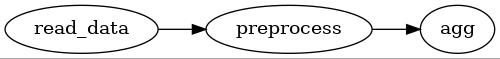

In [16]:
ray.dag.vis_utils.plot(agg_data, "output.jpg")

In [17]:
print(workflow.run(agg_data, workflow_id="run_5"))

2022-10-10 15:32:01,472	INFO api.py:203 -- Workflow job created. [id="run_5"].
2022-10-10 15:32:01,479	INFO api.py:279 -- Resuming workflow [id="run_5"].
2022-10-10 15:32:01,578	INFO api.py:292 -- Workflow job run_5 resumed.


285


In [18]:
out_ref = workflow.run_async(agg_data, workflow_id="run_6")

(WorkflowManagementActor pid=984165) 2022-10-10 15:32:01,645	INFO workflow_executor.py:86 -- Workflow job [id=run_5] started.
(WorkflowManagementActor pid=984165) 2022-10-10 15:32:01,657	INFO workflow_executor.py:122 -- Workflow 'run_5' completes successfully.
2022-10-10 15:32:01,781	INFO api.py:203 -- Workflow job created. [id="run_6"].


In [19]:
print(ray.get(out_ref))

285


In [20]:
workflow.get_status(workflow_id="run_6")


<WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>

In [21]:
workflow.delete(workflow_id="run_6")

In [22]:
workflow.list_all()

[('eeadcb5c-d37d-4558-82b3-1ccf56e98a2c.1665415129.552226305',
  <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>),
 ('5b4dbd56-b275-48f9-9c33-b6ae59fda78e.1665415617.249259472',
  <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>),
 ('9b3f4314-fb2e-4542-b80d-d72c6afd26eb.1665428557.474726915',
  <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>),
 ('gather', <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>),
 ('run_1', <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>),
 ('2f6fc67c-2679-4a19-a5a1-21edfa3d6d9e.1665430319.717717409',
  <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>),
 ('run_2', <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>),
 ('run_3', <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>),
 ('run_4', <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>),
 ('run_5', <WorkflowStatus.SUCCESSFUL: 'SUCCESSFUL'>)]

In [23]:
workflow_metadata = workflow.get_metadata("run_5")

In [24]:
workflow_metadata

{'status': 'SUCCESSFUL',
 'user_metadata': {},
 'stats': {'start_time': 1665430321.6257722, 'end_time': 1665430321.656522}}

In [25]:
event1_task = workflow.wait_for_event(workflow.event_listener.TimerListener, time.time()+ 60)
event2_task = workflow.wait_for_event(workflow.event_listener.TimerListener, time.time() +30)

@ray.remote
def gather(*args):
    return args

In [26]:
workflow.run(gather.bind(event1_task,event2_task), workflow_id="gather")

2022-10-10 15:32:03,254	INFO api.py:203 -- Workflow job created. [id="gather"].
2022-10-10 15:32:03,261	INFO api.py:279 -- Resuming workflow [id="gather"].
2022-10-10 15:32:03,289	INFO api.py:292 -- Workflow job gather resumed.


(None, None)

In [ ]:
ray.shutdown()